<img src="../Images/DSC_Logo.png" style="width: 400px;">

# Temperature Anomalies

![sky](../Images/temperature.jpg)

*Image modified from Gerd Altmann, Pixabay*

The objective in this notebook is to analyze and predict a dataset of global temperature anomalies from 1850 to 2024 against the 1901-2000 average with monthly frequency. The data is sourced from the NOAA National Centers for Environmental Information.

**Original dataset:** NOAA National Centers for Environmental information: Climate at a Glance: Global Time Series [Data set]. https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series, retrieved on August 23, 2024.

## **Exercise 1: Time Series Basics**

## 1. Load, Prepare and Plot Time Series Data

**Exercise:** Import the dataset of NOAA global temperature anomalies in monthly resolution. The path of the dataset is '../Datasets/NOAA_time_series_monthly.csv'. Print the first rows of the dataset to see it's structure.

In [1]:
import pandas as pd

path = '../Datasets/NOAA_time_series_monthly.csv' 
global_temp = pd.read_csv(path, skiprows=4, delimiter=',')

global_temp.head()

,Date,Anomaly
0,185001,-0.46
1,185002,-0.21
2,185003,-0.22
3,185004,-0.36
4,185005,-0.30


**Exercise:** convert 'Date' into a `datetime` object, set the date column as index for easy analysis and and check the structure of the dataset after conversion.

In [2]:
global_temp['Date'] = pd.to_datetime(global_temp['Date'].astype(str), format='%Y%m')
global_temp.set_index('Date', inplace=True) # Set the 'Date' column as the index
global_temp.head()

,Anomaly
Date,
1850-01-01,-0.46
1850-02-01,-0.21
1850-03-01,-0.22
1850-04-01,-0.36
1850-05-01,-0.30


**Exercise:** Print summary statistics of the time series.

In [3]:
global_temp.describe()

,Anomaly
count,2096.000000
mean,0.055468
std,0.374475
min,-0.740000
25%,-0.210000
50%,-0.040000
75%,0.222500
max,1.430000


**Exercise:** Plot the full time series and a subset of the time series covering only a few years to examine short-term patterns and variations in greater detail. Additionally, create bar plots to display the median temperature anomalies for each month over both the full time series and the time series subset, highlighting typical seasonal effects and recurring patterns.

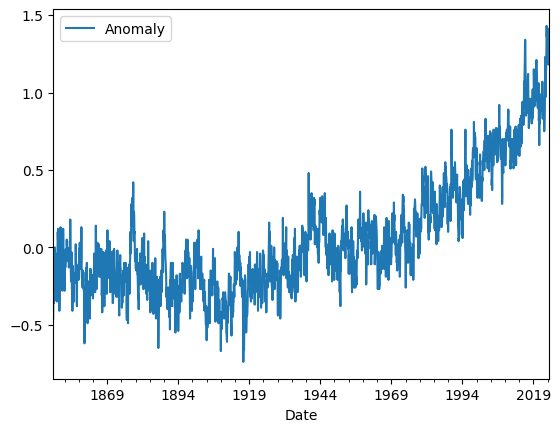

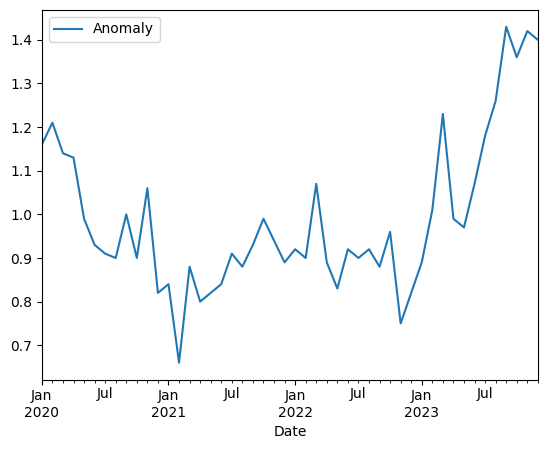

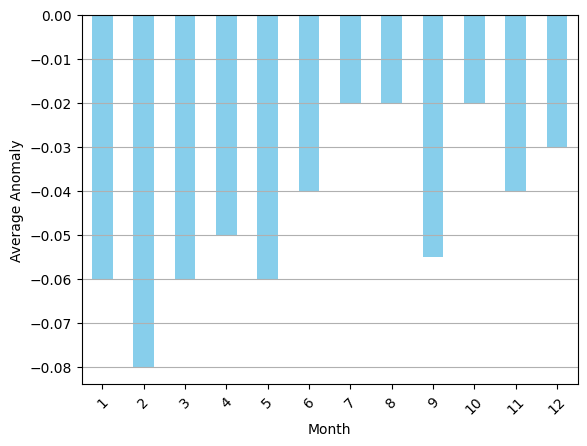

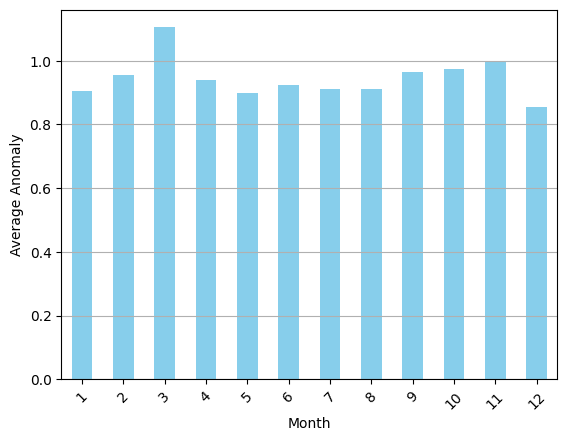

In [5]:
import matplotlib.pyplot as plt

# 1) time series plot
global_temp.plot()
plt.show()

# 2) time series plot - subset
global_temp['2020-01':'2023-12'].plot()
plt.show()

# 3) bar plot
    # Add column holding month
global_temp['month'] = global_temp.index.month
    # Calculate the average anomaly per month
average_anomalies = global_temp.groupby('month')['Anomaly'].median()
    # Create a bar plot using matplotlib
plt.figure()
average_anomalies.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Anomaly')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 4) bar plot - subset
    # Calculate the average anomaly per month
average_anomalies = global_temp['2020-01':'2023-12'].groupby('month')['Anomaly'].median()
    # Create a bar plot using matplotlib
plt.figure()
average_anomalies.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Anomaly')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## **Exercise 2: Exploration of Time Series Features**

## 2. Time Series Components

**Exercise:** Decompose the time series into the components trend, seasonal, and residual using an additive model from the `statsmodels` library. Conduct the decomposition also for the subset of data that you plotted in Exercise 1. Are the patterns as you would expect? Would you expect stationarity?

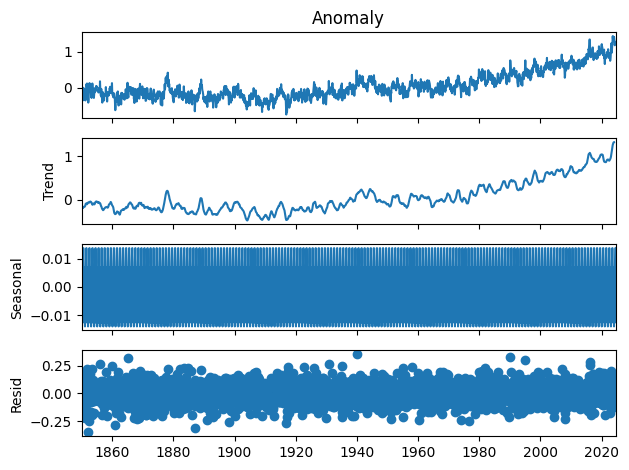

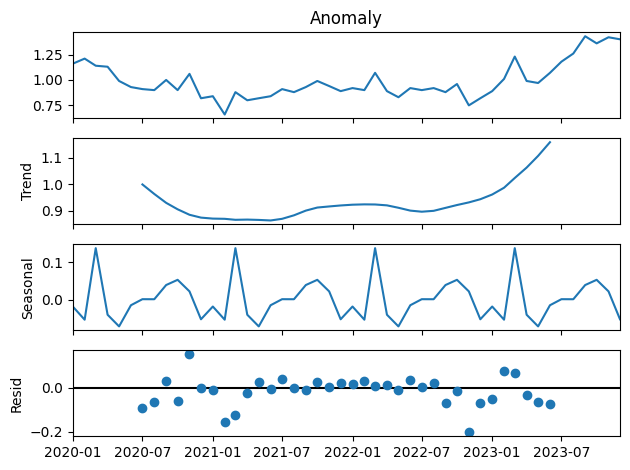

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 1) Decompose and plot the full time series
temp_decompose = seasonal_decompose(global_temp['Anomaly'], model='additive', period=12)
temp_decompose.plot()
plt.show()

# 2) Decompose and plot time series with specified period
    # Select data
start_date = '2020-01-01'
end_date = '2023-12-31'
df_period = global_temp[start_date:end_date]
    # Decompose and plot
result = seasonal_decompose(df_period['Anomaly'], model='additive', period=12)
result.plot()
plt.show()

Anomalies reflect changes in how much temperatures deviate from a baseline. These anomalies are calculated by taking the difference between observed temperatures and a long-term average. While this method can result in a series with a zero mean, the presence of an upward trend indicates non-stationarity, characteristic of climate data due to global warming. Although warming has not been uniform across the planet, the overall upward trend in globally averaged temperatures shows that more regions are experiencing warming than cooling, consistent with [current scientific understanding of climate change](https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature).

Simple additive decomposition is used to analyze seasonal patterns in time series data by averaging each month's values over the entire period. This analysis suggests variations in seasonal components, with peaks in the seasonal component observed in March and September to November, indicating that these months experience stronger warming trends according to the dataset. While climate change generally results in [longer warm seasons and shorter cold seasons](https://www.ipcc.ch/2021/08/09/ar6-wg1-20210809-pr/), regional variations can influence seasonal patterns in global analyses.

**Exercise:** Does the decomposition effectively capture the underlying structure of the time series by accurately separating the trend and seasonal components from random fluctuations? Use the `statsmodels` library to check the residuals for stationarity, test for normality, and assess their overall white noise behavior.

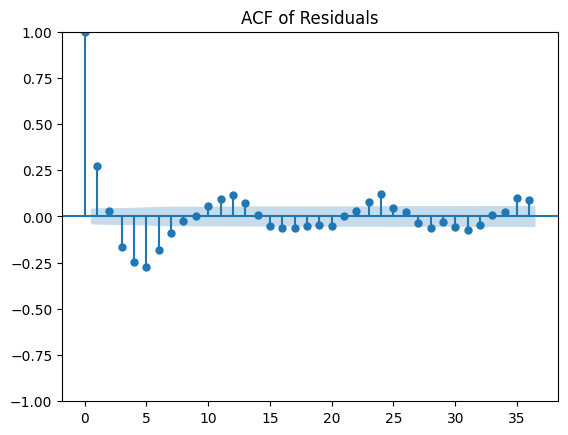

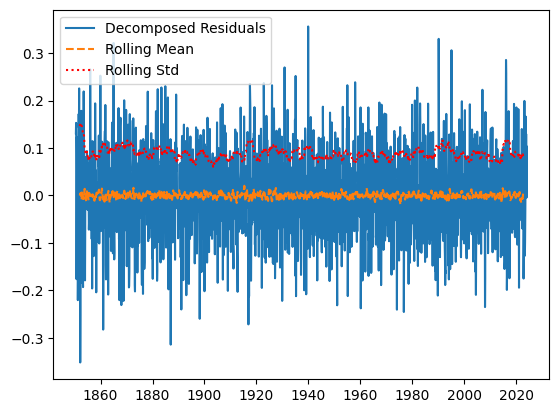

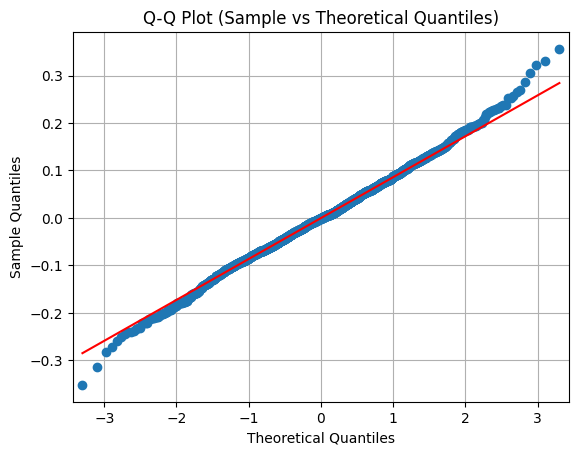

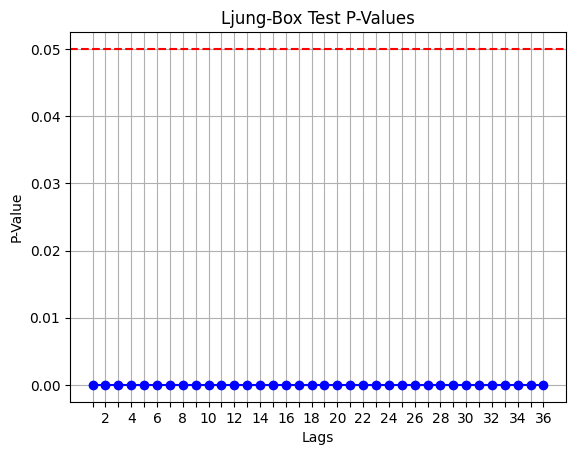

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

# Extract residuals and drop NaN values
temp_resid = temp_decompose.resid.dropna()

# Plot ACF of the residuals
plot_acf(temp_resid, lags=36)
plt.title('ACF of Residuals')
plt.show()

# Rolling mean and standard deviation
rolm = temp_resid.rolling(window=36, center=True).mean()
rolstd = temp_resid.rolling(window=36, center=True).std()

# Plotting residuals, rolling mean, and rolling std
plt.plot(temp_resid, label='Decomposed Residuals')
plt.plot(rolm, label='Rolling Mean', linestyle='--')
plt.plot(rolstd, label='Rolling Std', linestyle=':', c='red')
plt.legend()
plt.show()

# Q-Q plot to test for normality
plt.figure()
sm.qqplot(temp_resid, line='q', ax=plt.gca())
plt.title('Q-Q Plot (Sample vs Theoretical Quantiles)')
plt.grid()

from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np

# Perform the Ljung-Box test for residuals
    # Calculate Ljung-Box test statistics and p-values
ljung_box_results = acorr_ljungbox(temp_resid, lags=36, return_df=True)
    # Create a plot for the p-values
plt.figure()
plt.plot(ljung_box_results['lb_pvalue'], marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='r', linestyle='--')  # 5% significance level
plt.title('Ljung-Box Test P-Values')
plt.xlabel('Lags')
plt.ylabel('P-Value')
plt.xticks(np.arange(0, 37, 1))
plt.xticks(ljung_box_results.index)  # Set x-ticks to all lags
plt.gca().set_xticklabels([str(int(x)) if x % 2 == 0 else '' for x in ljung_box_results.index])
plt.grid()
plt.show()

The decomposition model needs adjustments, as the residuals still exhibit autocorrelation. Although the ACF plot shows decreasing autocorrelations beyond lag 1, the Ljung-Box test's extremely small p-values provide strong statistical evidence that some structure or correlation remains in the residuals. This can be expected given the complexity of climate data and the simple decomposition technique applied. 

## **Exercise 3: Time Series Model ARIMA**

## 3. Stationarity Test and Differencing

**Exercise:** Calculate the `kpss` statistics to test for stationarity.

In [8]:
from statsmodels.tsa.stattools import kpss

# KPSS test for stationarity
kpss_stat, p_value, lags, crit_values = kpss(global_temp['Anomaly'], regression='c', nlags='auto')

# Output the results of the KPSS test
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Lags: {lags}')
print('Critical Values:', crit_values)
if p_value < 0.05:
    print("The series is likely non-stationary.")
else:
    print("The series is likely stationary.")

KPSS Statistic: 5.303529068527813
p-value: 0.01
Lags: 28
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is likely non-stationary.


/tmp/ipykernel_103/3225542127.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, crit_values = kpss(global_temp['Anomaly'], regression='c', nlags='auto')


**Exercise:** The small p-value also means that the global temperature anomalies time series is likely non-stationary. Applying stationary time series models requires differencing the time series first. Conduct differencing the time series with a lag of 1 to remove trends and stabilize the mean of a time series by subtracting each observation from the previous one. Plot the resulting time series.

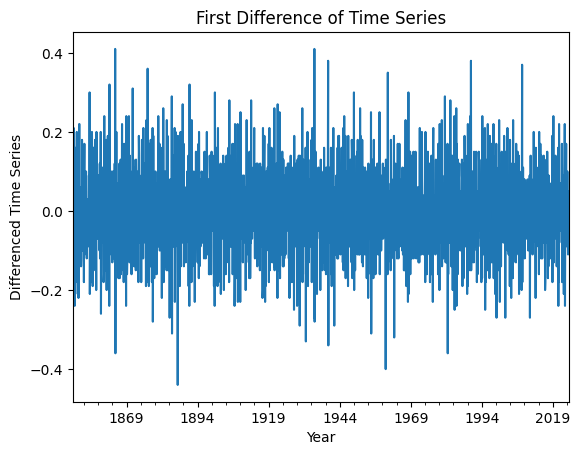

In [9]:
global_temp_diff = global_temp['Anomaly'].diff(1).dropna()

# Plot the differenced series
global_temp_diff.plot()
plt.title('First Difference of Time Series')
plt.xlabel('Year')
plt.ylabel('Differenced Time Series')
plt.show()

**Exercise:** Plot the ACF and PACF plots of the differenced time series and calculate the KPSS statistics to check again for stationarity.

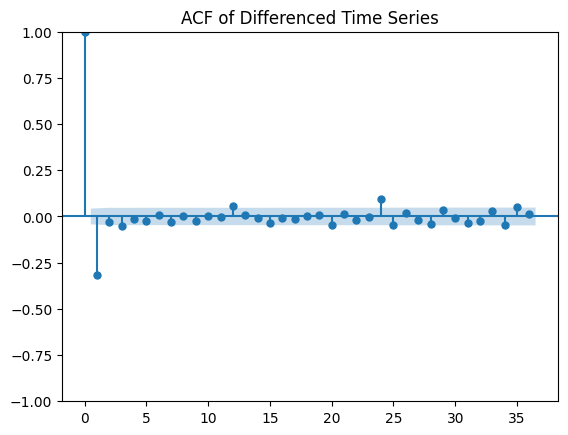

KPSS Statistic: 0.14231953158230717
p-value: 0.1
Lags: 69
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is likely stationary.


/tmp/ipykernel_103/1927355020.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, crit_values = kpss(global_temp_diff, regression='c', nlags='auto')


In [10]:
# Plot ACF using PythonTsa (PACF is not plotted here)
plot_acf(global_temp_diff, lags=36)
plt.title('ACF of Differenced Time Series')
plt.show()

# KPSS test for stationarity
kpss_stat, p_value, lags, crit_values = kpss(global_temp_diff, regression='c', nlags='auto')

# Output the results of the KPSS test
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Lags: {lags}')
print('Critical Values:', crit_values)
if p_value < 0.05:
    print("The series is likely non-stationary.")
else:
    print("The series is likely stationary.")

## 4. ARIMA

In [11]:
# Set the frequency of the index to avoid a warning when fitting the model
global_temp_diff.index = global_temp_diff.index.to_period('M').to_timestamp() 

**Exercise:** Use the `tsa.arma_order_select_ic` function from the `statsmodels` library to identify the best ARIMA model for the time series. Explore a range of autoregressive (p) and moving average (q) parameters. Analyze statistical metrics to determine the best parameters for the data.

Note: Running the loop to find the best model with the temperature anomalies time series can take a considerable amount of time because of it's length. Therefore choose a rather small range of parameters (e.g. 0 to 3).

In [12]:
# Choose model:
inf = sm.tsa.arma_order_select_ic(global_temp_diff, max_ar=3, max_ma=3, ic=['aic', 'bic', 'hqic'], trend='c')

print("Best AR term (p for minimum AIC):", inf.aic_min_order[0])
print("Best MA term (q for minimum AIC):", inf.aic_min_order[1])

print("Best AR term (p for minimum BIC):", inf.bic_min_order[0])
print("Best MA term (q for minimum BIC):", inf.bic_min_order[1])

print("Best AR term (p for minimum HQIC):", inf.hqic_min_order[0])
print("Best MA term (q for minimum HQIC):", inf.hqic_min_order[1])

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best AR term (p for minimum AIC): 1
Best MA term (q for minimum AIC): 2
Best AR term (p for minimum BIC): 1
Best MA term (q for minimum BIC): 2
Best AR term (p for minimum HQIC): 1
Best MA term (q for minimum HQIC): 2


**Exercise:** Based on your previous model selection process with the differenced time series, specify the optimal model parameters in the `ARIMA` function to fit the model on the original data with built-in differencing. Print the model summary.

In [13]:
global_temp = global_temp['Anomaly'].dropna()
global_temp.index = global_temp.index.to_period('M').to_timestamp() 

In [14]:
from statsmodels.tsa.arima.model import ARIMA
arima112 = ARIMA(global_temp, order=(1,1,2)).fit()
print(arima112.summary())

                               SARIMAX Results                                
Dep. Variable:                Anomaly   No. Observations:                 2096
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1879.205
Date:                Wed, 06 Nov 2024   AIC                          -3750.409
Time:                        16:57:40   BIC                          -3727.820
Sample:                    01-01-1850   HQIC                         -3742.135
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8337      0.025     33.328      0.000       0.785       0.883
ma.L1         -1.2639      0.034    -36.810      0.000      -1.331      -1.197
ma.L2          0.2870      0.030      9.477      0.0

**Exercise:** Analyze whether the ARIMA model fits the data well.

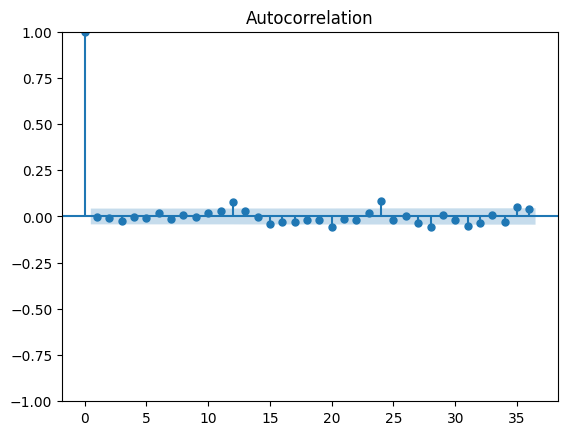

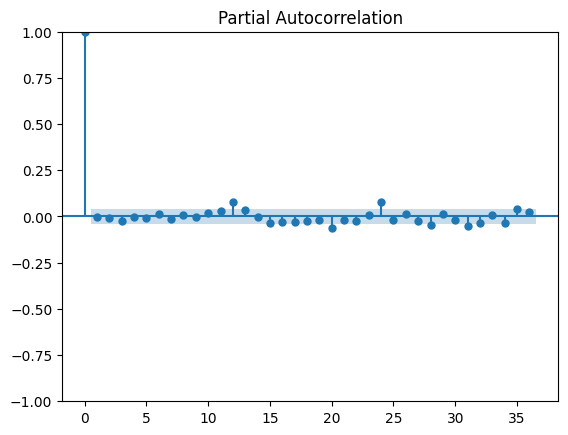

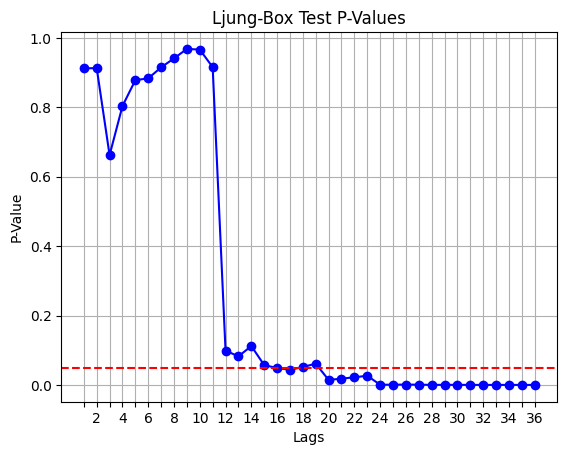

Normality test result: NormaltestResult(statistic=np.float64(28.064275554083384), pvalue=np.float64(8.052300877773174e-07))


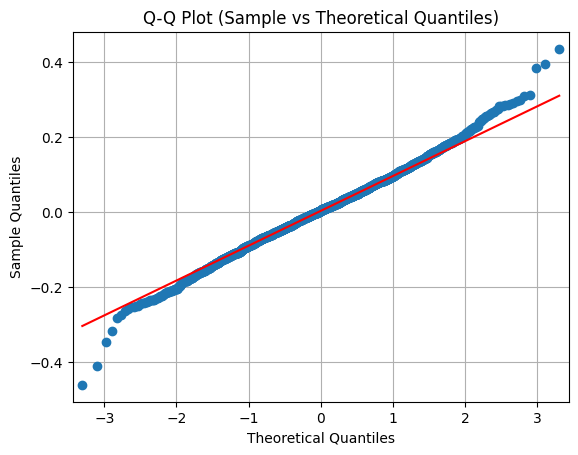

In [16]:
# Analyze the residuals
resid112 = arima112.resid

# Plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(resid112, lags=36)
plt.show()
plot_pacf(resid112, lags=36)
plt.show()

# Perform the Ljung-Box test for residuals
    # Calculate Ljung-Box test statistics and p-values
ljung_box_results = acorr_ljungbox(resid112, lags=36, return_df=True)
    # Create a plot for the p-values
plt.figure()
plt.plot(ljung_box_results['lb_pvalue'], marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='r', linestyle='--')  # 5% significance level
plt.title('Ljung-Box Test P-Values')
plt.xlabel('Lags')
plt.ylabel('P-Value')
plt.xticks(np.arange(0, 37, 1))
plt.xticks(ljung_box_results.index)  # Set x-ticks to all lags
plt.gca().set_xticklabels([str(int(x)) if x % 2 == 0 else '' for x in ljung_box_results.index])
plt.grid()
plt.show()

# Q-Q plot
plt.figure()
sm.qqplot(resid112, line='q', ax=plt.gca())
plt.title('Q-Q Plot (Sample vs Theoretical Quantiles)')
plt.grid()

# Perform the normality test on residuals
from scipy import stats 
normaltest_result = stats.normaltest(resid112)
print("Normality test result:", normaltest_result)

While the lack of significant autocorrelation at most lags and a scattered lag plot are positive signs, the normality of residuals is rejected. Let's see how the prediction would look like...

**Exercise:** Plot the fitted values and the out-sample foreast for 5 years.

/tmp/ipykernel_103/3940536271.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]


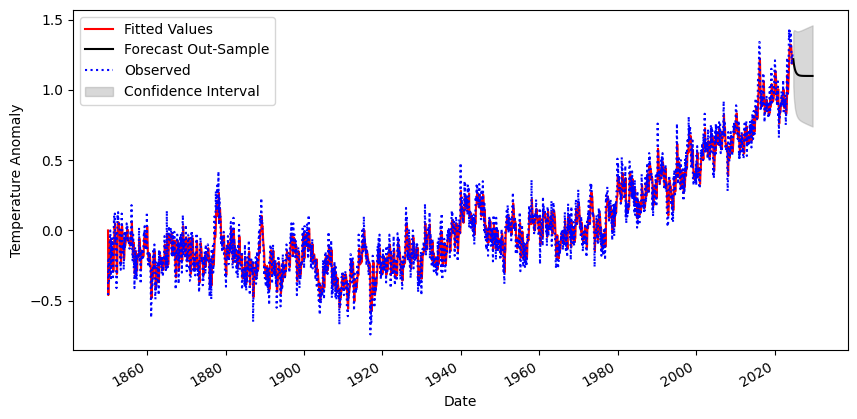

In [17]:
# Define out-sample forecast
forecast_steps = 5*12 # monthly data
forecast_series = arima112.forecast(steps=forecast_steps)
last_date = global_temp.index[-1]  # Get the last date of actual data
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]
forecast_result = arima112.get_forecast(steps=forecast_steps)
forecast_series = forecast_result.predicted_mean
forecast_conf = forecast_result.conf_int()

# Plot
plt.figure(figsize=(10, 5))
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly')
plt.plot(global_temp.index, arima112.fittedvalues, color="red", label="Fitted Values")
plt.plot(forecast_dates, forecast_series, color='black', label='Forecast Out-Sample')
global_temp.plot(color="blue", label="Observed", linestyle=":")
plt.fill_between(forecast_dates,
                 forecast_conf.iloc[:, 0],  # Lower confidence interval
                 forecast_conf.iloc[:, 1],  # Upper confidence interval
                 color='gray', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.show()

## **Exercise 4: Smoothed Time Series and Trend**

## 5. Overall Trend in Temperature Anomalies

Global temperature anomalies can be displayed together with the smoothed time series (based on different filtering techniques) and the linear trend line on the [NOAA website](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series).

**Exercise:** Apply smoothing to the original time series using a 5-year mean, calculate the trend using linear regression (use 'numerical_index' as the time component) and retreive the average warming in °C per decade.

In [20]:
# Convert the datetime index to a numerical format to avoid type conflicts in trend calculation
numerical_index = np.arange(len(global_temp))

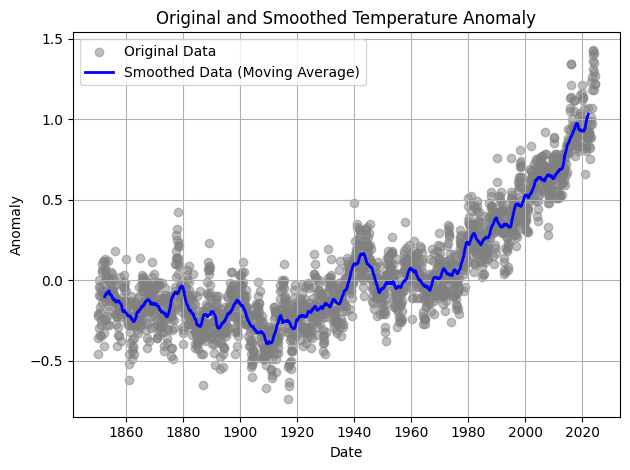

Average warming per decade: 0.0577 °C


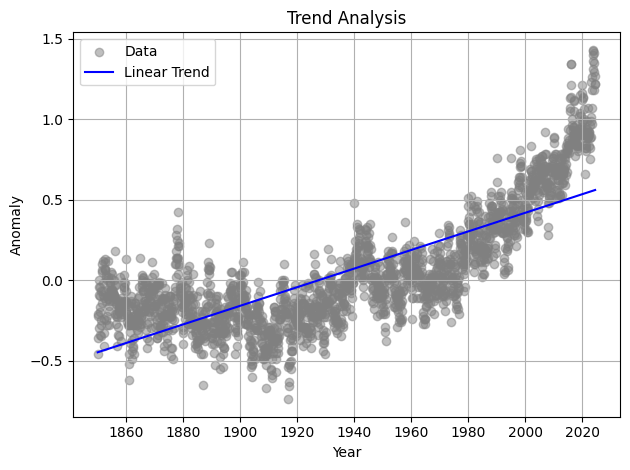

In [21]:
# 1) Smoothed time series

# Apply smoothing using a moving average
window_size = 12*5 # monthly data over 5 years
global_temp_smoothed = pd.Series(global_temp).rolling(window=window_size, center=True).mean().values

# Plotting the results
plt.figure()
plt.scatter(global_temp.index, global_temp, label='Original Data', color='gray', alpha=0.5)  # Original data
plt.plot(global_temp.index, global_temp_smoothed, label='Smoothed Data (Moving Average)', color='blue', linewidth=2)  # Smoothed data

# Adding titles and labels
plt.title('Original and Smoothed Temperature Anomaly')
plt.xlabel('Date')
plt.ylabel('Anomaly')  # Clarified y-axis label
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 2) Trend

# Fit OLS model
linear_model = sm.OLS(global_temp.values, sm.add_constant(numerical_index)).fit()

# Extracting the slope for the linear model
slope = linear_model.params[1]

# Convert to change per decade
slope_per_decade = slope * 12 * 10
print(f"Average warming per decade: {slope_per_decade:.4f} °C")

# Plotting the results with both the raw data and the fitted linear trend
plt.figure()
plt.scatter(global_temp.index, global_temp.values, label='Data', color='gray', alpha=0.5)
plt.plot(global_temp.index, linear_model.fittedvalues, label='Linear Trend', color='blue')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Anomaly')
plt.title('Trend Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()